In [1]:
%load_ext autoreload
%load_ext autotime

time: 285 µs (started: 2023-07-29 15:58:11 -07:00)


In [2]:
import sys
sys.path.append("../")
import warnings
warnings.filterwarnings('ignore')
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

time: 1.17 s (started: 2023-07-29 15:58:11 -07:00)


In [3]:
import dask.dataframe as dd
import numpy as np
import pandas as pd


time: 601 ms (started: 2023-07-29 15:58:13 -07:00)


In [4]:
%autoreload 2

from wisio.recorder import RecorderAnalyzer

log_dir = "/p/vast1/iopp/recorder_app_logs/hacc/nodes-32/workflow-0/_parquet"

recorder_analyzer = RecorderAnalyzer(
    cluster_manager_args=dict(
        force_local=True,
        cluster_settings=dict(
            cores=4,
            dashboard_port=3656,
            local_directory="/var/tmp/dask-recorder",
            log_file="%J.log",
            worker_queue="pdebug"
        )
    ),
    working_dir='.recorder',
    debug=True
) 

recorder_analyzer

time: 2.61 s (started: 2023-07-29 15:58:13 -07:00)


In [5]:
recorder_analyzer.cluster_manager.clients[0]

<Client: 'tcp://127.0.0.1:40119' processes=4 threads=36>

time: 46.7 ms (started: 2023-07-29 15:58:18 -07:00)


In [8]:
%autoreload 2

res = recorder_analyzer.analyze_parquet(log_dir=log_dir, checkpoint=False, metrics=['duration', 'bw', 'iops'])

time: 23.4 s (started: 2023-07-29 15:58:51 -07:00)


(<Figure size 500x500 with 1 Axes>, <Axes: >)

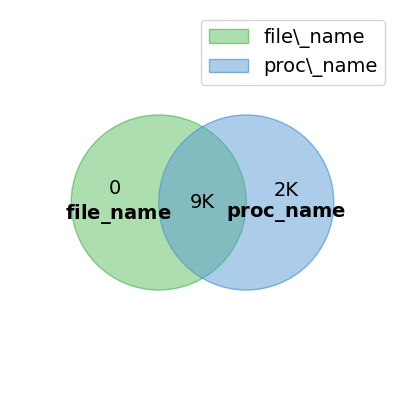

time: 763 ms (started: 2023-07-29 15:59:15 -07:00)


In [9]:
res.plot.view_relations2('duration', ('file_name',), ('proc_name',))

(<Figure size 500x500 with 1 Axes>, <Axes: >)

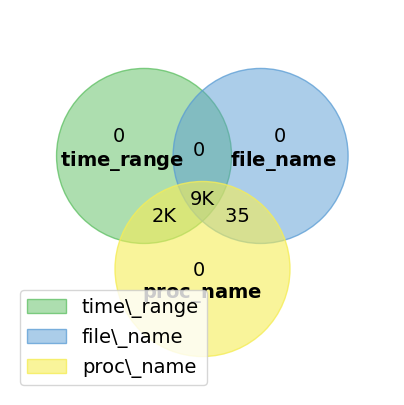

time: 794 ms (started: 2023-07-29 15:59:16 -07:00)


In [10]:
res.plot.view_relations3('duration', ('time_range',), ('file_name',), ('proc_name',))

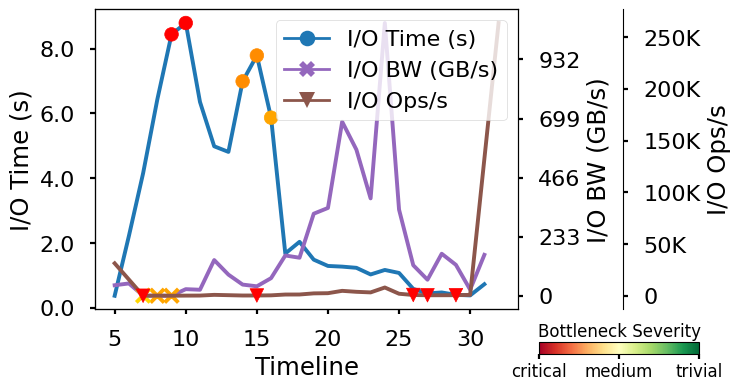

time: 1.93 s (started: 2023-07-29 16:37:18 -07:00)


In [14]:
fig = res.plot.bottleneck_timeline3(
    metric1='duration', 
    metric2='bw', 
    metric3='iops', 
    label1='I/O Time (s)',
    label2='I/O BW (GB/s)',
    label3='I/O Ops/s',
    figsize=(8, 4),
    threshold=0.1,
    sample_count=5,    
)

In [7]:
main_view, views, bottlenecks = res

time: 680 µs (started: 2023-03-29 22:46:14 -07:00)


In [8]:
from wisio.rules import Rule
from wisio._recorder.rules import RecorderRuleEngine

rules = dict(
    file_name=[Rule.BOTT_METADATA_ACCESS, Rule.BOTT_SMALL_READS, Rule.BOTT_SMALL_WRITES],
    proc_name=[Rule.BOTT_METADATA_ACCESS],
    trange=[],
)

rule_engine = RecorderRuleEngine(rules=rules)

rule_engine


time: 12.1 ms (started: 2023-03-29 22:46:14 -07:00)


In [9]:
%autoreload 2

characteristics = rule_engine.process_characteristics(view=main_view)
characteristics


{<Rule.CHAR_IO_TIME: 118>: RuleResult(data_dict=None, description='I/O Time', detail_list=None, reasons=None, rule=<Rule.CHAR_IO_TIME: 118>, value=10.367437948642419, value_fmt='10.37 seconds'),
 <Rule.CHAR_IO_SIZE: 116>: RuleResult(data_dict=None, description='Total Size', detail_list=None, reasons=None, rule=<Rule.CHAR_IO_SIZE: 116>, value=8632884264960, value_fmt='8040.00 GB'),
 <Rule.CHAR_READ_IO_SIZE: 125>: RuleResult(data_dict=None, description='Read Size', detail_list=None, reasons=None, rule=<Rule.CHAR_READ_IO_SIZE: 125>, value=848256040960, value_fmt='790.00 GB (9.83%)'),
 <Rule.CHAR_WRITE_IO_SIZE: 130>: RuleResult(data_dict=None, description='Write Size', detail_list=None, reasons=None, rule=<Rule.CHAR_WRITE_IO_SIZE: 130>, value=848256040960, value_fmt='790.00 GB (9.83%)'),
 <Rule.CHAR_READ_XFER_SIZE: 132>: RuleResult(data_dict=None, description='Read Xfer', detail_list=['16-64 MB - 1,382 ops (51.92%)', '>64 MB - 1,280 ops (48.08%)'], reasons=None, rule=<Rule.CHAR_READ_XFER_S

time: 241 ms (started: 2023-03-29 22:46:15 -07:00)


In [10]:
from rich.console import Console
from rich.panel import Panel
from rich.table import Table
from rich.tree import Tree

# Create a new Table object from Rich library
table = Table(box=None, show_header=False)

# Add columns to the table for the key and value
table.add_column(style="cyan")
table.add_column()

# Add each key-value pair to the table as a row
for rule, result in characteristics.items():
    if result.detail_list is None:
        table.add_row(result.description, result.value_fmt)
    else:
        detail_tree = Tree(result.value_fmt)
        for detail in result.detail_list:
            detail_tree.add(detail)
        table.add_row(result.description, detail_tree)

# Create a Console object from Rich library
console = Console()

# Print the table with Rich formatting
console.print(Panel(table, title='Summary'))


╭──────────────────────────────────────────────────── Summary ────────────────────────────────────────────────────╮
│  I/O Time          10.37 seconds                                                                                │
│  Total Size        8040.00 GB                                                                                   │
│  Read Size         790.00 GB (9.83%)                                                                            │
│  Write Size        790.00 GB (9.83%)                                                                            │
│  Read Xfer         64 MB->64 MB - 2,662 ops                                                                     │
│                    ├── 16-64 MB - 1,382 ops (51.92%)                                                            │
│                    └── >64 MB - 1,280 ops (48.08%)                                                              │
│  Write Xfer        64 MB->64 MB - 2,954 ops                                                                     │
│                    ├── 16-64 MB - 1,674 ops (56.67%)                                                            │
│                    └── >64 MB - 1,280 ops (43.33%)                                                              │
│  Total I/O Ops     72,928 ops                                                                                   │
│  Read I/O Ops      12,800 ops (17.55%)                                                                          │
│  Write I/O Ops     12,800 ops (17.55%)                                                                          │
│  Metadata I/O Ops  47,328 ops (64.90%)                                                                          │
│  Apps              1 apps                                                                                       │
│                    └── app1 - 10.37 s (100.00%) - 790.00/790.00 GB R/W (9.83/9.83%) - 72,928 ops (100.00%)      │
│  Nodes             1 nodes                                                                                      │
│                    └── localhost - 10.37 s (100.00%) - 790.00/790.00 GB R/W (9.83/9.83%) - 72,928 ops           │
│                        (100.00%)                                                                                │
│  File Count        2561 files                                                                                   │
│  Shared/FPP        2561 Shared (100.00%) - 0 FPP (0.00%)                                                        │
│  Access Pattern    100.00% Sequential - 0.00% Random                                                            │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

time: 151 ms (started: 2023-03-29 22:46:19 -07:00)


In [14]:
processed_bottlenecks = rule_engine.process_bottlenecks(bottlenecks=bottlenecks, characteristics=characteristics, threshold=0.5)
processed_bottlenecks

{('file_name',): {<Rule.BOTT_METADATA_ACCESS: 207>: {'/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data': RuleResult(data_dict={'llc': {'duration_sum': 6.4871999524928015, 'index_count': 48, 'size_min': 0, 'size_max': 763363328, 'size_sum': 6744440832, 'read_time': 0.7544080056250095, 'write_time': 1.8765517708379775, 'metadata_time': 3.8562401760298144, 'read_size': 662700032, 'write_size': 662700032, 'metadata_size': 5419040768, 'read_count': 10, 'write_count': 10, 'metadata_count': 28, 'read_min': 58720256, 'read_max': 201326592, 'write_min': 192937984, 'write_max': 260046848, 'metadata_min': 1493172224, 'metadata_max': 2390753280, 'data_count': 20, 'data_size': 1325400064, 'data_time': 2.630959776462987, 'sequential_time': 2.630959776462987, 'random_time': 0.0, 'sequential_size': 1325400064, 'random_size': 0, 'sequential_count': 20, 'random_count': 0, 'close_time': 0.00041419998660785495, 'open_time': 3.855711876044552, 'seek_time': 0.0001140999986546376, 'stat_time': 

time: 19.8 s (started: 2023-03-29 22:56:07 -07:00)


In [13]:
from rich.tree import Tree
from rich.console import Console

# create a tree object
tree = Tree("Bottlenecks")

for view_key, bottleneck_dict in processed_bottlenecks.items():
    branch_name = '_'.join(view_key) if isinstance(view_key, tuple) else view_key
    branch = tree.add(branch_name)
    for rule, rule_results in bottleneck_dict.items():
        subbranch = branch.add(rule.name)
        for bottleneck_key, result in rule_results.items():
            subbranch.add(result.description)


# create a console object and print the tree
console = Console()
console.print(tree)


Bottlenecks
├── file_name
│   └── BOTT_METADATA_ACCESS
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000000-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 59.44% (3.86 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000001-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 60.51% (3.84 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000002-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 58.83% (3.84 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000003-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 60.31% (3.84 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000004-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 59.63% (3.85 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000005-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 58.54% (3.84 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000006-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 58.82% (3.86 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000007-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 59.67% (3.85 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000008-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 58.30% (3.84 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000009-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 58.71% (3.85 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000010-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 60.36% (3.82 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000011-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-31th second(s) and spent 60.69% (3.81 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000012-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 59.78% (3.82 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000013-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 60.00% (3.84 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test-Part00000014-of-00001280.data' is accessed by 1 process(es) during 
│       │   the 13, 15, 19-21, 23, and 30-32th second(s) and spent 59.73% (3.86 seconds) of its I/O time on the 
│       │   'open' operation(s).
│       ├── '/p/gpfs1/iopp/temp/hacc_dir/test

time: 783 ms (started: 2023-03-23 09:57:09 -07:00)


In [8]:
!rm -rf {log_dir}/bottlenecks

time: 394 ms (started: 2023-03-12 17:34:12 -07:00)


In [9]:
recorder_analyzer.save_bottlenecks(log_dir=log_dir, bottlenecks=bottlenecks)


time: 1min 29s (started: 2023-03-12 17:34:12 -07:00)


In [10]:
!chmod g+r {log_dir}/bottlenecks/*
!ls -lh {log_dir}/bottlenecks

total 313M
-rw-r--r-- 1 izzet iopp 18M Mar 12 17:34 file_name.json
-rw-r--r-- 1 izzet iopp 25M Mar 12 17:34 file_name_proc_name.json
-rw-r--r-- 1 izzet iopp 21M Mar 12 17:35 file_name_proc_name_trange.json
-rw-r--r-- 1 izzet iopp 21M Mar 12 17:34 file_name_trange.json
-rw-r--r-- 1 izzet iopp 25M Mar 12 17:35 file_name_trange_proc_name.json
-rw-r--r-- 1 izzet iopp 25M Mar 12 17:34 proc_name.json
-rw-r--r-- 1 izzet iopp 18M Mar 12 17:35 proc_name_file_name.json
-rw-r--r-- 1 izzet iopp 21M Mar 12 17:35 proc_name_file_name_trange.json
-rw-r--r-- 1 izzet iopp 21M Mar 12 17:35 proc_name_trange.json
-rw-r--r-- 1 izzet iopp 18M Mar 12 17:35 proc_name_trange_file_name.json
-rw-r--r-- 1 izzet iopp 21M Mar 12 17:34 trange.json
-rw-r--r-- 1 izzet iopp 18M Mar 12 17:34 trange_file_name.json
-rw-r--r-- 1 izzet iopp 25M Mar 12 17:35 trange_file_name_proc_name.json
-rw-r--r-- 1 izzet iopp 25M Mar 12 17:34 trange_proc_name.json
-rw-r--r-- 1 izzet iopp 18M Mar 12 17:35 trange_proc_name_file_name.json
ti